# training

> Training loop

In [ ]:
#|default_exp training

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from isaacai.utils import *
from isaacai.dataloaders import *
from isaacai.models import *

from datetime import datetime, timedelta
import torchvision.transforms.functional as TF,torch.nn.functional as F
import math, time

import matplotlib.pyplot as plt
import matplotlib as mpl
import fastcore.all as fc
import torch
from torch import nn, Tensor
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import pandas as pd , numpy as np
from torcheval.metrics import MulticlassAccuracy,Mean

import dill as pickle
from torch.optim.lr_scheduler import ExponentialLR
from fastprogress.fastprogress import master_bar, progress_bar
import inspect


In [ ]:
#|hide
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)
from IPython.display import clear_output

In [ ]:
xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

_dataset = load_dataset('fashion_mnist').with_transform(transformi)
_dataset = sample_dataset_dict(_dataset)
dls = DataLoaders.from_dataset_dict(_dataset, 64, num_workers=4)
clear_output()

# Base Learner

In [ ]:
#| export
class BasicTrainCB:
    def predict(self,trainer): trainer.preds = trainer.model(trainer.batch[0])
    def get_loss(self,trainer): trainer.loss = trainer.loss_func(trainer.preds,trainer.batch[1])
    def backward(self,trainer): trainer.loss.backward()
    def step(self,trainer): trainer.opt.step()
    def zero_grad(self,trainer): trainer.opt.zero_grad()

In [ ]:
#| export
class DeviceCB:
    def __init__(self, device=def_device): self.device=device
    def before_fit(self, trainer):
        if hasattr(trainer.model, 'to'): trainer.model.to(self.device)
    def before_batch(self, trainer): trainer.batch = to_device(trainer.batch, device=self.device)

In [ ]:
#| export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#| export
class MetricsCB:
    def __init__(self, precision=4, **metrics):
        self._precision=precision
        self.metrics = metrics
        self.metrics.update({'train_loss':Mean(),'valid_loss':Mean()})
        
    def _log(self,x): print(x)
    
    def before_batch(self,trainer): self.batch_size = len(trainer.batch[1])
    
    def after_batch(self,trainer):
        if trainer.training: 
            self.metrics['train_loss'].update(to_cpu(trainer.loss),weight=self.batch_size)
        else: 
            self.metrics['valid_loss'].update(to_cpu(trainer.loss),weight=self.batch_size)
            for name, metric in self.metrics.items():
                if name in ('train_loss','valid_loss'): continue
                self.metrics[name].update(to_cpu(trainer.preds),to_cpu(trainer.batch[1]))
            
    def before_epoch(self,trainer):  self._st = datetime.now()
    def after_epoch(self,trainer):
        # compute metrics and append to epoch stats and display
        if not trainer.training:
            log = {name:float(metric.compute()) for name, metric in self.metrics.items()}
            log['epoch'] = trainer.epoch
            log['elapsed'] = datetime.now() - self._st
            self._log(log)
            [metric.reset() for metric in self.metrics.values()]

In [ ]:
#| export
class TrackingCB:
    def __init__(self):
        self._log_epoch,self._log_batch, self._log_fit = [pd.DataFrame()]*3
        
    def before_fit(self,trainer):
        trainer.epochs = master_bar(trainer.epochs)
        setattr(getattr(trainer,'MetricsCB'),'_log',self._log)
        log = {'model':str(trainer.model),'model_type':str(type(trainer.model)),'model_source':inspect.getsource(trainer.model.__class__)}
        log['callbacks'] = str(trainer.callbacks)

        for callback in trainer.callbacks:
            cb = getattr(trainer,callback)
            for cb_attr in dir(cb):
                if cb_attr.startswith('_'): continue
                if callable(getattr(cb,cb_attr)): continue
                log[cb_attr] = str(getattr(cb,cb_attr))
        self._log(log)
        
    def before_epoch(self,trainer):
        trainer.batches = progress_bar(trainer.batches,parent=trainer.epochs)
        trainer.epochs.child.comment = "Training" if trainer.training else "Validation"
        
    def _log(self,x):
        x = PPDict(x)        
        if 'epoch' in x.keys(): trainer.epochs.write(str(x))
        log = pd.DataFrame(x,index=[""])
        if 'batch' in x.keys(): self._log_batch = pd.concat([self._log_batch,log])
        elif 'epoch' in x.keys(): self._log_epoch = pd.concat([self._log_epoch,log])
        else: self._log_fit = pd.concat([self._log_fit,log])
        
        

In [ ]:
#| export 
class Trainer:
    def subclassing_method(self,**kwargs): pass

    def __init__(self, dls, loss_func, opt_func, model, callbacks,**kwargs):
        self.add_callbacks(callbacks)
        fc.store_attr(but='callbacks')
        self.subclassing_method(**kwargs)
            
    @with_cbs('batch', CancelBatchException)
    def one_batch(self):
        self.run_callbacks(['predict','get_loss'])
        if self.training: self.run_callbacks(['before_backward','backward','step','zero_grad'])
    
    @with_cbs('epoch',CancelEpochException)
    def _one_epoch(self):
        for self.batch_num,self.batch in zip(self.batches,self.dl): self.one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self.batches = range(len(self.dl))
        self._one_epoch()

    @with_cbs('fit', CancelFitException)
    def _fit(self,train, valid):
        for self.epoch in self.epochs: 
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)
    
    def fit(self, n_epochs=3, lr=1e-3, callbacks=None,train=True,valid=True):
        callbacks = fc.L(callbacks)
        self.add_callbacks(callbacks)
        self.opt = self.opt_func(self.model.parameters(), lr)
        self.epochs = range(n_epochs)
        self._fit(train,valid)
        self.callbacks = [o for o in self.callbacks if o not in callbacks]
                                                        
    @property
    def training(self): return self.model.training
    
    def add_callbacks(self,callbacks): add_callbacks(self,callbacks)

    def run_callbacks(self,method_names): 
        cbs = [getattr(self,o) for o in self.callbacks]
        for method_name in fc.L(method_names): run_callbacks(cbs,method_name,self)

In [ ]:
trainer = Trainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.Adam, 
                  SimpleNet(28*28,64,10), 
                  callbacks=[BasicTrainCB(),MetricsCB(accuracy=MulticlassAccuracy()), DeviceCB(),TrackingCB()])

In [ ]:
trainer.fit()

In [ ]:
#| export
class MomentumTrainCB(BasicTrainCB):
    def __init__(self,momentum): self.momentum = momentum
    def zero_grad(self,trainer): 
        with torch.no_grad():
            for p in trainer.model.parameters(): p.grad *= self.momentum

In [ ]:
#| export
def init_delegates(trainer,method='subclassing_method'):
    trainer.__init__ = fc.delegates(getattr(trainer,method))(copy_func(trainer.__init__))
    return trainer   

In [ ]:
#| export
@init_delegates
class MomentumTrainer(Trainer):
    def subclassing_method(self,precision=0.85): 
        self.add_callbacks([MomentumTrainCB(precision),DeviceCB(),TrackingCB()])

In [ ]:
trainer = MomentumTrainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.SGD, 
                  SimpleNet(28*28,64,10), 
                  callbacks=[MetricsCB(Accuracy=MulticlassAccuracy())])

In [ ]:
trainer.fit()

In [ ]:
#| export
class LRFinderCB:
    order = 1
    def __init__(self,lr_mult=1.3): fc.store_attr()
    
    def before_fit(self,trainer):
        pickle.dump(trainer,open('_tmp.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
        self.scheduler = ExponentialLR(optimizer=trainer.opt,gamma=self.lr_mult)
        self.lrs, self.losses = fc.L(), fc.L()
        self.min = math.inf
        
    def before_batch(self,trainer):
        if not trainer.training: raise CancelEpochException()
        
    def after_batch(self,trainer):
        self.lrs.append(trainer.opt.param_groups[0]['lr'])
        loss = to_cpu(trainer.loss)
        self.losses.append(loss)        
        if loss < self.min: self.min = loss
        if loss > self.min * 3: raise CancelEpochException()
        self.scheduler.step()
        
    def after_fit(self,_):
        plt.figure(figsize=(12,4))
        plt.plot(self.lrs,self.losses)
        plt.xscale('log')
        plt.title('Learning Rate Finder'); plt.xlabel('Learning Rate'); plt.ylabel('Losses') 
        plt.show()
        global trainer
        trainer = pickle.load(open('_tmp.pkl','rb'))

In [ ]:
trainer = MomentumTrainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.SGD, 
                  SimpleNet(28*28,64,10), 
                  callbacks=[MetricsCB(Accuracy=MulticlassAccuracy())])

In [ ]:
trainer.fit()

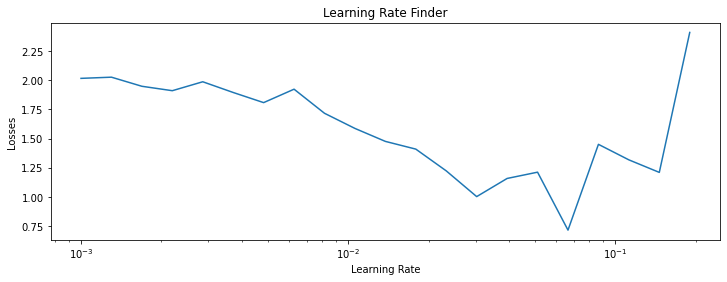

In [ ]:
trainer.fit(callbacks=[LRFinderCB()])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()